# Transfer Learning Example (VGG16 pre-trained on ImageNet for Cifar-10)

In [20]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt


#pretrained model on  https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Dataset

In [38]:

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
learning_rate = 1e-4
num_epochs = 10
batch_size = 128



train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])



train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=train_transforms,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=train_transforms)



train_dataset,old_data = torch.utils.data.random_split(train_dataset,
                                           [5000,45000])

test_dataset,old_data = torch.utils.data.random_split(test_dataset,
                                           [1000,9000])

Device: cuda:0
Files already downloaded and verified


In [39]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


### Loading the Pre-Trained Model

In [41]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Freezing the Model

First, we are going to freeze the whole model:

what does it means?

In [42]:
for param in model.parameters():
    param.requires_grad = False

In [43]:
model.classifier[3].requires_grad = True

Now, replace the output layer with your own output layer (here, we actually add two more output layers):

In [44]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, NUM_CLASSES))

### Training 

In [45]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

In [46]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0040 | Cost: 2.3652
Epoch: 001/010 | Train: 81.060% | Loss: 0.535
Time elapsed: 7.21 min
Epoch: 002/010 | Batch 0000/0040 | Cost: 0.5881
Epoch: 002/010 | Train: 84.040% | Loss: 0.474
Time elapsed: 14.39 min
Epoch: 003/010 | Batch 0000/0040 | Cost: 0.7004
Epoch: 003/010 | Train: 85.860% | Loss: 0.427
Time elapsed: 21.58 min
Epoch: 004/010 | Batch 0000/0040 | Cost: 0.4089
Epoch: 004/010 | Train: 88.120% | Loss: 0.377
Time elapsed: 28.78 min
Epoch: 005/010 | Batch 0000/0040 | Cost: 0.4844
Epoch: 005/010 | Train: 86.900% | Loss: 0.390
Time elapsed: 35.99 min
Epoch: 006/010 | Batch 0000/0040 | Cost: 0.4661
Epoch: 006/010 | Train: 89.800% | Loss: 0.319
Time elapsed: 43.19 min
Epoch: 007/010 | Batch 0000/0040 | Cost: 0.3608
Epoch: 007/010 | Train: 90.520% | Loss: 0.302
Time elapsed: 50.39 min
Epoch: 008/010 | Batch 0000/0040 | Cost: 0.3711
Epoch: 008/010 | Train: 91.580% | Loss: 0.280
Time elapsed: 57.59 min
Epoch: 009/010 | Batch 0000/0040 | Cost: 0.3131
Epoch: 00

In [47]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 81.70%


In [49]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)
    

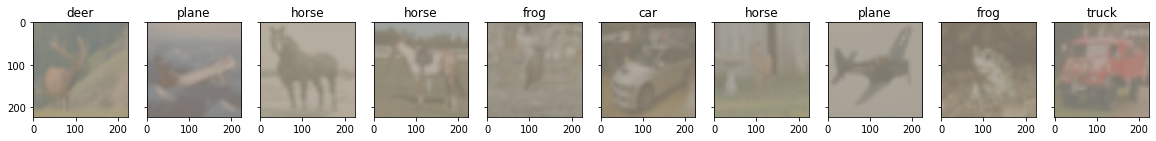

In [51]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])